# **Object Detection**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

### **Utility functions**

In [2]:
def box_corner_to_center(boxes):
    """
    boxes: (num_boxes, x1, y1, x2, y2)
    where (x1,y1) is the upper corner left coordinate
    and   (x2, y2) is the bottom corner right coo
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [3]:
def draw_bbox(image, coords):
    
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    
    x_min, x_max, y_min, y_max = coords
    rect = plt.Rectangle((x_min * 256.0, y_min * 256.0), x_max * 256.0 - x_min * 256.0, y_max * 256.0 - y_min * 256.0, 
                         linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

### **Create Anchor Boxes**

In [4]:
class CreateAnchorBoxes:
    """
    Takes image scale size to generate coordinates of all anchor boxes given ratios and sizes.
    
    image: (batch_size, channel, width, height)
    sizes: 1D list
    ratios: 1D list
    """
    def __init__(self, image, sizes, ratios):
        self.image_height, self.image_width = image.shape[-2], image.shape[-1]
        self.sizes = torch.tensor(sizes, device='cuda')
        self.ratios = torch.tensor(ratios, device='cuda')
        self.num_boxes = len(sizes) * len(ratios)
        self.create_grid_center_points()
        self.create_anchor_width_height()

    def create_grid_center_points(self):
        self.center_x_axis = (torch.arange(self.image_width, device='cuda') + 0.5) / self.image_width
        self.center_y_axis = (torch.arange(self.image_height, device='cuda') + 0.5) / self.image_height
        self.grid_x_coords, self.grid_y_coords = torch.meshgrid(self.center_x_axis, self.center_y_axis)
        self.grid_x_coords = self.grid_x_coords.reshape(-1)
        self.grid_y_coords = self.grid_y_coords.reshape(-1)

    def create_anchor_width_height(self):
        width_anchor = torch.tensor([], device='cuda')
        height_anchor = torch.tensor([], device='cuda')

        for size in self.sizes:
            for ratio in self.ratios:
                width_anchor = torch.cat((width_anchor, size * torch.sqrt(ratio).unsqueeze(0)))
                height_anchor = torch.cat((height_anchor, size / torch.sqrt(ratio).unsqueeze(0)))

        self.grid_width_height = torch.stack(
            (-width_anchor, -height_anchor,
             width_anchor, height_anchor)
        ).T.repeat(self.image_height * self.image_width, 1) / 2

    def mapping(self):
        out_grid = torch.stack(
            [self.grid_x_coords, self.grid_y_coords,
             self.grid_x_coords, self.grid_y_coords],
            dim=1).repeat_interleave(self.num_boxes, dim=0)
        return out_grid + self.grid_width_height

### **Intersection Over Union**

In [5]:
def multibox_prior(data, sizes, ratios):
    # Get height and width of the input tensor
    in_height, in_width = data.shape[-2:]

    # Determine device and other relevant constants
    device = data.device
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1

    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / in_height, 1.0 / in_width

    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Compute anchor box widths and heights
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # Create anchor box manipulations
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Generate the grid of shifts
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations

    return output.unsqueeze(0)

In [6]:
def calculate_box_area(boxes):
    return ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])).cuda()

def BoxIou(boxes1, boxes2):
    boxes1 = boxes1.cuda()
    boxes2 = boxes2.cuda()

    areas1 = calculate_box_area(boxes1)
    areas2 = calculate_box_area(boxes2)

    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [7]:
def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = BoxIou(anchors, ground_truth)

    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device="cuda")

    max_ious, indices = torch.max(jaccard, dim=1)
    if isinstance(iou_threshold, float):
        iou_threshold = torch.tensor(iou_threshold, device=max_ious.device)
        
    anc_i = torch.nonzero(max_ious >= iou_threshold, as_tuple=False).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        
    return anchors_bbox_map

### **Post Prediction**

In [8]:
def offset_boxes(anchors, assigned_bboxes, sigma_xy=0.1, sigma_wh=0.2, mean=0, eps=1e-6):
    center_anchors = box_corner_to_center(anchors.cuda())  # Assuming anchors are on CUDA
    center_assigned_bboxes = box_corner_to_center(assigned_bboxes.cuda())  # Assuming assigned_bboxes are on CUDA
    offset_xy = ((center_assigned_bboxes[:, :2] - center_anchors[:, :2]) / center_anchors[:, 2:] - mean) / sigma_xy
    offset_wh = (torch.log(eps + center_assigned_bboxes[:, 2:] / center_anchors[:, 2:] - mean)) / sigma_wh
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset


def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)

        class_labels = torch.zeros(num_anchors, dtype=torch.long, device="cuda")
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device="cuda")

        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

## **Training**

### **Prepare dataset**

### **Configuration**

In [9]:
# We have 5 scales
depths = [64, 128, 128, 128, 128]
width =  [32, 16,   8,   4,   1]
height = [32, 16,   8,   4,   1]


X_multiscale = [
    torch.randn(1, depths[0], width[0], height[0]),
    torch.randn(1, depths[1], width[1], height[1]),
    torch.randn(1, depths[2], width[2], height[2]),
    torch.randn(1, depths[3], width[3], height[3]),
    torch.randn(1, depths[4], width[4], height[4]),
]

sizes = [[0.2,  0.272], 
         [0.37, 0.447], 
         [0.54, 0.619], 
         [0.71, 0.79], 
         [0.88, 0.961]]

ratios = [[1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5]]

num_anchors_per_pixel = len(sizes[0]) * len(ratios[0]) - 2
print(f"Each group (pixel) has {num_anchors_per_pixel} anchor boxes")

Each group (pixel) has 4 anchor boxes


### **Prepare the anchor boxes**

In [11]:
def prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel):
    
    anchors_multiscale = []

    for i in range(len(X_multiscale)):
        # create_anchor_func = CreateAnchorBoxes(
        #     image=X_multiscale[i], 
        #     sizes=sizes[i], 
        #     ratios=ratios[i]
        # )
        # anchors = create_anchor_func.mapping()
        anchors = multibox_prior(X_multiscale[i], sizes[i], ratios[i])
        anchors_multiscale.append(anchors)
        
        total_anchors = X_multiscale[i].shape[2] * X_multiscale[i].shape[3] * num_anchors_per_pixel
        print(f"Total anchor boxes are: {total_anchors} -> anchor shape: {anchors.shape}")
        
    anchors_multiscale = torch.cat(anchors_multiscale, dim=1)
    return anchors_multiscale
        
anchors_multiscale = prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel)
print(anchors_multiscale.shape)

Total anchor boxes are: 4096 -> anchor shape: torch.Size([1, 4096, 4])
Total anchor boxes are: 1024 -> anchor shape: torch.Size([1, 1024, 4])
Total anchor boxes are: 256 -> anchor shape: torch.Size([1, 256, 4])
Total anchor boxes are: 64 -> anchor shape: torch.Size([1, 64, 4])
Total anchor boxes are: 4 -> anchor shape: torch.Size([1, 4, 4])
torch.Size([1, 5444, 4])


### **Prepare the Network**

**Base Network**

In [13]:
class Downsampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        return self.layers(x)
        
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Downsampling(3, 16),
            Downsampling(16, 32),
            Downsampling(32, 64),
        )
        
    def forward(self, x):
        x =  self.layers(x)
        print(x.shape)
        return x

In [14]:
class ScaleModule(nn.Module):
    def __init__(self, in_channel, out_channel, num_classes, num_anchors, baseNet=None, avg_pool=False):
        super().__init__()
        
        if baseNet is not None:
            self.downsample = baseNet
        elif avg_pool:
            self.downsample = nn.AdaptiveMaxPool2d((1,1))
        else:
            self.downsample = Downsampling(in_channel, out_channel)
            
        self.cls_head = nn.Conv2d(out_channel, num_anchors * (num_classes + 1), kernel_size=3, padding=1)
        self.bbox_head = nn.Conv2d(out_channel, num_anchors * 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.downsample(x)
        cls_pred = self.cls_head(x)
        bbox_pred = self.bbox_head(x)
        return x, cls_pred, bbox_pred
    

class SSD(nn.Module):
    def __init__(self, num_classes, num_anchors):
        super().__init__()
        self.num_classes = num_classes
        self.base_net = BaseNet()
        self.scale_module_1 = ScaleModule(3, 64, num_classes, num_anchors, baseNet=self.base_net)
        self.scale_module_2 = ScaleModule(64, 128, num_classes, num_anchors)
        self.scale_module_3 = ScaleModule(128, 128, num_classes, num_anchors)
        self.scale_module_4 = ScaleModule(128, 128, num_classes, num_anchors)
        self.scale_module_5 = ScaleModule(128, 128, num_classes, num_anchors, avg_pool=True)
        
    def flatten_pred(self, pred):
        return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
        
    def concat_preds(self, preds):
        return torch.cat([self.flatten_pred(pred) for pred in preds], dim=1)
        
    def post_process(self):
        self.cls_preds = self.concat_preds(self.cls_preds)
        self.cls_preds = self.cls_preds.reshape(self.cls_preds.shape[0], -1, self.num_classes + 1)
        self.bbox_preds = self.concat_preds(self.bbox_preds)
            
    def forward(self, x):
        
        self.cls_preds, self.bbox_preds = [], []
        
        x, cls_pred, bbox_pred = self.scale_module_1(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_2(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_3(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_4(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_5(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        self.post_process()
        
        return x, self.cls_preds, self.bbox_preds

In [15]:
X = torch.rand(12, 3, 256, 256).cuda()
Y = torch.rand(12, 1, 5).cuda()
model = SSD(num_classes=1, num_anchors=4).cuda()
x_, cls_preds, bbox_preds = model(X)
x_.shape, anchors_multiscale.shape, cls_preds.shape, bbox_preds.shape

torch.Size([12, 64, 32, 32])


(torch.Size([12, 128, 1, 1]),
 torch.Size([1, 5444, 4]),
 torch.Size([12, 5444, 2]),
 torch.Size([12, 21776]))

### **Dataset**

In [16]:
def read_data_bananas(is_train=True, data_dir="../dataset/Banana/"):

    """Read the banana detection dataset images and labels."""
    
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []

    for img_name, target in csv_data.iterrows():

        """
        Here `target` contains (class, upper-left x, upper-left y,
        lower-right x, lower-right y), where all the images have the same
        banana class (index 0)
        """

        images.append(
            torchvision.io.read_image(
              os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')
            )
        )
        targets.append(list(target))
  
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [17]:
class BananasDataset(torch.utils.data.Dataset):

    """A customized dataset to load the banana detection dataset."""
    
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [18]:
def load_data_bananas(batch_size):

    """Load the banana detection dataset."""
    
    train_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=True),
        batch_size, shuffle=True
    )
    val_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=False),
        batch_size
    )
    return train_iter, val_iter

In [20]:
train_loader, val_loader = load_data_bananas(batch_size=12)

read 1000 training examples
read 100 validation examples


### **Training**

In [21]:
num_epochs = 20
model = SSD(num_classes=1, num_anchors=4).cuda()

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    
    cls = cls_loss(
        cls_preds.reshape(-1, num_classes),
        cls_labels.reshape(-1)
    ).reshape(batch_size, -1).mean(dim=1)
    
    bbox = bbox_loss(
        bbox_preds * bbox_masks,
        bbox_labels * bbox_masks
    ).mean(dim=1)
    
    return cls + bbox

optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=5e-4)

In [22]:
class Accumulator:

    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
metric = Accumulator(4)

In [23]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [21]:
min_cls_err = 100000
min_bbox_mae = 100000 

for epoch in range(num_epochs):
    model.train()
    for X, Y in train_loader:
        optimizer.zero_grad()
        X = X.cuda()
        Y = Y.cuda()
        x_, cls_preds, bbox_preds = model(X)
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors_multiscale, Y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks).mean()
        
        loss.backward()
        optimizer.step()
        metric.add (
            cls_eval(cls_preds, cls_labels), 
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
    break
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f"Epoch: {epoch+1} --- Class error: {cls_err} --- Box MAE: {bbox_mae}")
    
    if (cls_err < min_cls_err and bbox_mae < min_bbox_mae):
        min_loss = loss
        min_bbox_mae = bbox_mae
        torch.save(model.state_dict(), "../.cache/models/ssd.pt")

# print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')

Epoch: 1 --- Class error: 0.007804188096987463 --- Box MAE: 0.004714810760296241
Epoch: 2 --- Class error: 0.006308688464364387 --- Box MAE: 0.0044475290528296725
Epoch: 3 --- Class error: 0.005707629194219965 --- Box MAE: 0.0042980724169347844
Epoch: 4 --- Class error: 0.00534202792064653 --- Box MAE: 0.004184395562367436
Epoch: 5 --- Class error: 0.00509309331373986 --- Box MAE: 0.004087881135064657
Epoch: 6 --- Class error: 0.0049142481018858986 --- Box MAE: 0.004003057822274893
Epoch: 7 --- Class error: 0.004783378818095985 --- Box MAE: 0.003928018743924033
Epoch: 8 --- Class error: 0.004667110580455547 --- Box MAE: 0.003862410348798316
Epoch: 9 --- Class error: 0.004574189729773859 --- Box MAE: 0.0038040900307097177
Epoch: 10 --- Class error: 0.004496381337252053 --- Box MAE: 0.00375178613851913
Epoch: 11 --- Class error: 0.004432285752454801 --- Box MAE: 0.00370606725630449
Epoch: 12 --- Class error: 0.0043741580945383385 --- Box MAE: 0.003664865618735413
Epoch: 13 --- Class erro

### **Non-max Suppresesion**

In [32]:
def offset_inverse(anchors, offset_preds):
    
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

def nms(boxes, scores, iou_threshold):
    
    """Sort confidence scores of predicted bounding boxes."""
    
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = [] 
    
    while B.numel() > 0:
        i = B[0]
        keep.append(i)        
        if B.numel() == 1: break

        iou = BoxIou(
            boxes[i, :].reshape(-1, 4),
            boxes[B[1:], :].reshape(-1, 4)
        ).reshape(-1)
        
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
        
    return torch.tensor(keep, device=boxes.device)

In [33]:
def multibox_detection(
    cls_probs, offset_preds, 
    anchors, nms_threshold=0.5,
    pos_threshold=0.009999999
):
    
    """Predict bounding boxes using non-maximum suppression."""
    
    batch_size = cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    
    for i in range(batch_size):
        
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        
        # Find all non-`keep` indices and set the class to background
        
        all_idx = torch.arange(num_anchors, dtype=torch.long, device="cuda")
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        
        pred_info = torch.cat((
            class_id.unsqueeze(1),
            conf.unsqueeze(1),
            predicted_bb), dim=1)
        
        out.append(pred_info)
        
    return torch.stack(out)

In [23]:
X = torchvision.io.read_image('../dataset/Banana/bananas_train/images/8.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()
X.shape

torch.Size([1, 3, 256, 256])

### **Inference**

In [37]:
def predict(X):
    model.eval()
    x_, cls_preds, bbox_preds = model(X.cuda())
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors_multiscale.cuda())
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [43]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""

    return plt.Rectangle (
        xy=(bbox[0], bbox[1]), 
        width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )

In [39]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(
                rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0)
            )

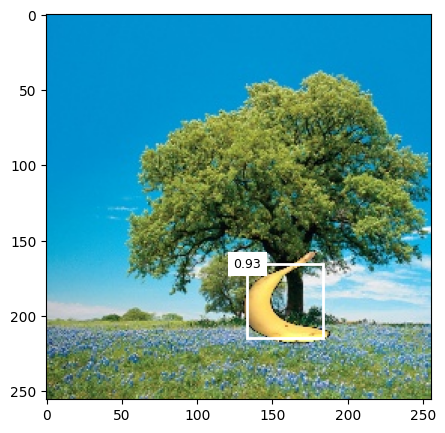

In [44]:
def display(img, output, threshold):
    plt.figure(figsize=(5, 5))
    fig = plt.imshow(img)
    
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)